In [141]:
##IMPORT ##

import pandas as pd
pd.set_option('display.max_columns', None)
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.Supervised import LazyRegressor

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

import xgboost as xgb



## Load Data

In [142]:
%reload_kedro
df_champs = catalog.load('df_champs_elysee_days_meteo_bank')

[12/05/22 20:35:55] INFO     No path argument was provided. Using: C:\Users\Erwan                    __init__.py:56
                             BOULLIER\Desktop\Datathon\BCG_Hackaton\datathon-bcg-gamma                             

[12/05/22 20:35:56] INFO     Kedro project Datathon BCG Gamma                                        __init__.py:77

                    INFO     Defined global variable 'context', 'session', 'catalog' and 'pipelines' __init__.py:78

                    INFO     Registered line magic 'run_viz'                                         __init__.py:84

                    INFO     Loading data from 'df_champs_elysee_days_meteo_bank'               data_catalog.py:343
                             (ParquetDataSet)...                                                                   

## Pipelines

In [143]:
##Fenetrage
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""

	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(2)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(2)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(2)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	df = df.merge(agg, left_index=True, right_index=True)
	# drop rows with NaN values
	if dropnan:
		df.dropna(inplace=True)
	return df


In [194]:
df_preprocessed_champs = series_to_supervised(df_champs, 48, 24)
df_preprocessed_champs = df_preprocessed_champs.drop(columns=["Taux d'occupation","Débit horaire"]) 
y_taux_t = df_preprocessed_champs['var1(t)']
y_debit_t = df_preprocessed_champs['var2(t)']
X = df_preprocessed_champs.drop(columns=['var1(t)','var2(t)'])
X = X.drop(columns=['Libelle','Date et heure de comptage','date'])

## Data split 
offset = int(X.shape[0] * 0.7)
X_train, y_taux_train, y_debit_train = X[:offset], y_taux_t[:offset], y_debit_t[:offset]
X_test, y_taux_test, y_debit_test = X[offset:], y_taux_t[offset:], y_debit_t[offset:]

## Features type declaration
min_max_columns = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
numerical_col = [feature for feature in list(X) if feature not in min_max_columns]




In [195]:
df_preprocessed_champs

Libelle 
 Date et heure de comptage 
 date 
 vacances 
 MAX_TEMPERATURE_C 
 MIN_TEMPERATURE_C 
 WINDSPEED_MAX_KMH 
 TEMPERATURE_MORNING_C 
 TEMPERATURE_NOON_C 
 TEMPERATURE_EVENING_C 
 PRECIP_TOTAL_DAY_MM 
 VISIBILITY_AVG_KM 
 WINDTEMP_MAX_C 
 TOTAL_SNOW_MM 
 UV_INDEX 
 SUNHOUR 
 est_ferie 
 year_2021 
 year_2022 
 hour_0 
 hour_1 
 hour_2 
 hour_3 
 hour_4 
 hour_5 
 hour_6 
 hour_7 
 hour_8 
 hour_9 
 hour_10 
 hour_11 
 hour_12 
 hour_13 
 hour_14 
 hour_15 
 hour_16 
 hour_17 
 hour_18 
 hour_19 
 hour_20 
 hour_21 
 hour_22 
 hour_23 
 day_1 
 day_2 
 day_3 
 day_4 
 day_5 
 day_6 
 day_7 
 day_8 
 day_9 
 day_10 
 day_11 
 day_12 
 day_13 
 day_14 
 day_15 
 day_16 
 day_17 
 day_18 
 day_19 
 day_20 
 day_21 
 day_22 
 day_23 
 day_24 
 day_25 
 day_26 
 day_27 
 day_28 
 day_29 
 day_30 
 day_31 
 wday_Monday 
 wday_Tuesday 
 wday_Wednesday 
 wday_Thursday 
 wday_Friday 
 wday_Saturday 
 wday_Sunday 
 month_1 
 month_2 
 month_3 
 month_4 
 month_5 
 month_6 
 month_7 
 month_8 
 month_9 
 month_10 
 month_11 
 month_12 
 var1(t-48) 
 var2(t-48) 
 var1(t-47) 
 var2(t-47) 
 var1(t-46) 
 var2(t-46) 
 var1(t-45) 
 var2(t-45) 
 var1(t-44) 
 var2(t-44) 
 var1(t-43) 
 var2(t-43) 
 var1(t-42) 
 var2(t-42) 
 var1(t-41) 
 var2(t-41) 
 var1(t-40) 
 var2(t-40) 
 var1(t-39) 
 var2(t-39) 
 var1(t-38) 
 var2(t-38) 
 var1(t-37) 
 var2(t-37) 
 var1(t-36) 
 var2(t-36) 
 var1(t-35) 
 var2(t-35) 
 var1(t-34) 
 var2(t-34) 
 var1(t-33) 
 var2(t-33) 
 var1(t-32) 
 var2(t-32) 
 var1(t-31) 
 var2(t-31) 
 var1(t-30) 
 var2(t-30) 
 var1(t-29) 
 var2(t-29) 
 var1(t-28) 
 var2(t-28) 
 var1(t-27) 
 var2(t-27) 
 var1(t-26) 
 var2(t-26) 
 var1(t-25) 
 var2(t-25) 
 var1(t-24) 
 var2(t-24) 
 var1(t-23) 
 var2(t-23) 
 var1(t-22) 
 var2(t-22) 
 var1(t-21) 
 var2(t-21) 
 var1(t-20) 
 var2(t-20) 
 var1(t-19) 
 var2(t-19) 
 var1(t-18) 
 var2(t-18) 
 var1(t-17) 
 var2(t-17) 
 var1(t-16) 
 var2(t-16) 
 var1(t-15) 
 var2(t-15) 
 var1(t-14) 
 var2(t-14) 
 var1(t-13) 
 var2(t-13) 
 var1(t-12) 
 var2(t-12) 
 var1(t-11) 
 var2(t-11) 
 var1(t-10) 
 var2(t-10) 
 var1(t-9) 
 var2(t-9) 
 var1(t-8) 
 var2(t-8) 
 var1(t-7) 
 var2(t-7) 
 var1(t-6) 
 var2(t-6) 
 var1(t-5) 
 var2(t-5) 
 var1(t-4) 
 var2(t-4) 
 var1(t-3) 
 var2(t-3) 
 var1(t-2) 
 var2(t-2) 
 var1(t-1) 
 var2(t-1) 
 var1(t) 
 var2(t) 
 var1(t+1) 
 var2(t+1) 
 var1(t+2) 
 var2(t+2) 
 var1(t+3) 
 var2(t+3) 
 var1(t+4) 
 var2(t+4) 
 var1(t+5) 
 var2(t+5) 
 var1(t+6) 
 var2(t+6) 
 var1(t+7) 
 var2(t+7) 
 var1(t+8) 
 var2(t+8) 
 var1(t+9) 
 var2(t+9) 
 var1(t+10) 
 var2(t+10) 
 var1(t+11) 
 var2(t+11) 
 var1(t+12) 
 var2(t+12) 
 var1(t+13) 
 var2(t+13) 
 var1(t+14) 
 var2(t+14) 
 var1(t+15) 
 var2(t+15) 
 var1(t+16) 
 var2(t+16) 
 var1(t+17) 
 var2(t+17) 
 var1(t+18) 
 var2(t+18) 
 var1(t+19) 
 var2(t+19) 
 var1(t+20) 
 var2(t+20) 
 var1(t+21) 
 var2(t+21) 
 var1(t+22) 
 var2(t+22) 
 var1(t+23) 
 var2(t+23) 
 var1(t+24) 
 var2(t+24) 
 var1(t+25) 
 var2(t+25) 
 var1(t+26) 
 var2(t+26) 
 var1(t+27) 
 var2(t+27) 
 var1(t+28) 
 var2(t+28) 
 var1(t+29) 
 var2(t+29) 
 var1(t+30) 
 var2(t+30) 
 var1(t+31) 
 var2(t+31) 
 var1(t+32) 
 var2(t+32) 
 var1(t+33) 
 var2(t+33) 
 var1(t+34) 
 var2(t+34) 
 var1(t+35) 
 var2(t+35) 
 var1(t+36) 
 var2(t+36) 
 var1(t+37) 
 var2(t+37) 
 var1(t+38) 
 var2(t+38) 
 var1(t+39) 
 var2(t+39) 
 var1(t+40) 
 var2(t+40) 
 var1(t+41) 
 var2(t+41) 
 var1(t+42) 
 var2(t+42) 
 var1(t+43) 
 var2(t+43) 
 var1(t+44) 
 var2(t+44) 
 var1(t+45) 
 var2(t+45) 
 var1(t+46) 
 var2(t+46) 
 var1(t+47) 
 var2(t+47) 
 var1(t+48) 
 var2(t+48) 
 var1(t+49) 
 var2(t+49) 
 var1(t+50) 
 var2(t+50) 
 var1(t+51) 
 var2(t+51) 
 var1(t+52) 
 var2(t+52) 
 var1(t+53) 
 var2(t+53) 
 var1(t+54) 
 var2(t+54) 
 var1(t+55) 
 var2(t+55) 
 var1(t+56) 
 var2(t+56) 
 var1(t+57) 
 var2(t+57) 
 var1(t+58) 
 var2(t+58) 
 var1(t+59) 
 var2(t+59) 
 var1(t+60) 
 var2(t+60) 
 var1(t+61) 
 var2(t+61) 
 var1(t+62) 
 var2(t+62) 
 var1(t+63) 
 var2(t+63) 
 var1(t+64) 
 var2(t+64) 
 var1(t+65) 
 var2(t+65) 
 var1(t+66) 
 var2(t+66) 
 var1(t

In [189]:

##Pipelines Scikit Learn
ct_scaler = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numerical_col),
        ("scaler_minmax", MinMaxScaler(), min_max_columns),
        
    ]
)

pipeline_master = Pipeline([
    ("preprocessor", ct_scaler),
    ])


In [190]:
## Data normalization
X_train_preprocessed = pipeline_master.fit_transform(X_train)
X_test_preprocessed = pipeline_master.transform(X_test)

### Data processing using diff (WIP)

### Data processing for times series (WIP new nb)

## Data vizualisation

## Models 

*XGboost regressor with only t to predict* <br>  
Prédire la différence <br> 
Grid search 

In [191]:
## Prediction of taux at t : 
model_taux_t = xgb.XGBRegressor()
model_taux_t = model_taux_t.fit(X_train_preprocessed,y_taux_train)


In [192]:
## Prediction of débit at t : 
model_debit_t = xgb.XGBRegressor()
model_debit_t = model_debit_t.fit(X_train_preprocessed, y_debit_train)

In [193]:
y_pred_taux_t = model_taux_t.predict(X_test_preprocessed)
MSE_taux = mean_squared_error(y_taux_test, y_pred_taux_t)


y_pred_debit_t = model_debit_t.predict(X_test_preprocessed)
MSE_debit = mean_squared_error(y_debit_test, y_pred_debit_t)

print(MSE_taux**0.5,MSE_debit**0.5)

3.4394455255644907 88.02499048477465


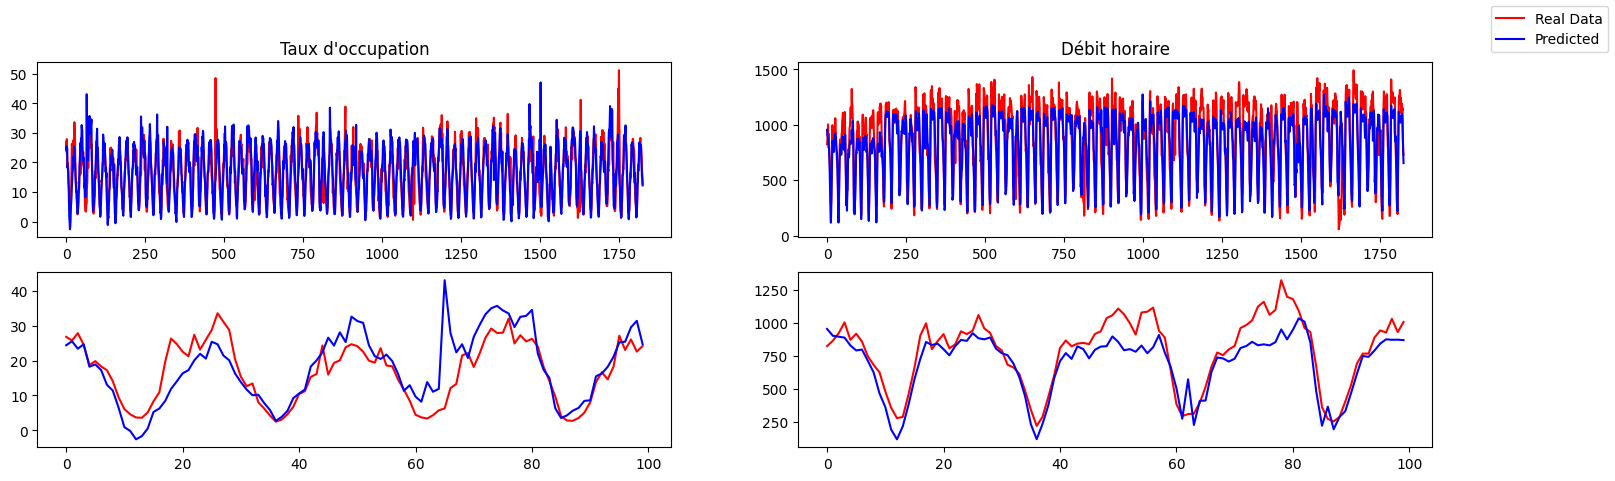

In [150]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux = len(y_taux_test)
t_taux = np.arange(n_taux)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux,y_taux_test, 'r')
ax[0,0].plot(t_taux,y_pred_taux_t, 'b')
ax[0,0].title.set_text("Taux d'occupation")
n_debit= len(y_debit_test)
t_debit = np.arange(n_debit)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit,y_debit_test, 'r')
ax[0,1].plot(t_debit,y_pred_debit_t, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_test[:100], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_t[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_test[:100], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_t[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

_Optimisation of the fenetrage_

In [151]:
def find_optimal (df) : 
    dic = {
        'Taux':{},
        'Débit':{}
    }
    for i in range(1,101,2):
        df_preprocessed_champs_opt = series_to_supervised(df, i, 1)
        y_taux_t = df_preprocessed_champs_opt['var1(t)']
        y_debit_t = df_preprocessed_champs_opt['var2(t)']
        X = df_preprocessed_champs_opt.drop(columns=['var1(t)','var2(t)'])

        ## Data split 
        offset = int(X.shape[0] * 0.7)
        X_train_opt, y_taux_train_opt, y_debit_train_opt = X[:offset], y_taux_t[:offset], y_debit_t[:offset]
        X_test, y_taux_test_opt, y_debit_test_opt = X[offset:], y_taux_t[offset:], y_debit_t[offset:]
        ## Data normalization
        X_train_preprocessed_opt = pipeline_master.fit_transform(X_train_opt)
        X_test_preprocessed_opt = pipeline_master.transform(X_test)

        ## Prediction of taux at t : 
        model_taux_t_opt = xgb.XGBRegressor()
        model_taux_t_opt = model_taux_t_opt.fit(X_train_preprocessed_opt,y_taux_train_opt)

        ## Prediction of débit at t : 
        model_debit_t_opt = xgb.XGBRegressor()
        model_debit_t_opt = model_debit_t_opt.fit(X_train_preprocessed_opt, y_debit_train_opt)
        
        y_pred_taux_t_opt = model_taux_t_opt.predict(X_test_preprocessed_opt)
        MSE_taux_opt = mean_squared_error(y_taux_test_opt, y_pred_taux_t_opt)

        y_pred_debit_t_opt = model_debit_t_opt.predict(X_test_preprocessed_opt)
        MSE_debit_opt = mean_squared_error(y_debit_test_opt, y_pred_debit_t_opt)
        dic['Taux'][i] =  MSE_taux_opt**0.5
        dic['Débit'][i] =  MSE_debit_opt**0.5
    return dic


Opt sont autour de 53 pour le taux et 17 pour le débit

In [ ]:
dic_opt = find_optimal(df_champs)

_XGB boost using only time data & fenetrage_

In [153]:
df_time_only = catalog.load('champs_elysee_with_days')

[12/05/22 20:37:02] INFO     Loading data from 'champs_elysee_with_days' (ParquetDataSet)...    data_catalog.py:343

In [154]:
df_time_only = df_time_only.drop(columns=['Libelle','Date et heure de comptage','date','vacances'])
df_time_only = pd.get_dummies(df_time_only, columns=['year'], prefix='year')
df_time_only = pd.get_dummies(df_time_only, columns=['hour'], prefix='hour')
df_time_only = pd.get_dummies(df_time_only, columns=['day'], prefix='day')
df_time_only = pd.get_dummies(df_time_only, columns=['day_of_week'], prefix='wday')
df_time_only = pd.get_dummies(df_time_only, columns=['month'], prefix='month')

In [155]:
df_time_only_preprocessd = series_to_supervised(df_time_only, 48, 1)
df_time_only_preprocessd = df_time_only_preprocessd.drop(columns=["Taux d'occupation","Débit horaire"]) 
y_taux_t_time_only = df_time_only_preprocessd['var1(t)']
y_debit_t_time_only = df_time_only_preprocessd['var2(t)']
X_time_only = df_time_only_preprocessd.drop(columns=['var1(t)','var2(t)'])


In [156]:
##Split
X_train_time_only, y_taux_train_time_only, y_debit_train_time_only = X_time_only[:offset], y_taux_t_time_only[:offset], y_debit_t_time_only[:offset]
X_test_time_only, y_taux_test_time_only, y_debit_test_time_only = X_time_only[offset:], y_taux_t_time_only[offset:], y_debit_t_time_only[offset:]

In [157]:
model_taux_time_only = xgb.XGBRegressor()
model_taux_time_only = model_taux_time_only.fit(X_train_time_only,y_taux_train_time_only) 

model_debit_time_only = xgb.XGBRegressor()
model_debit_time_only = model_debit_time_only.fit(X_train_time_only,y_debit_train_time_only) 


In [158]:
y_pred_taux_time_only_t = model_taux_time_only.predict(X_test_time_only)
RMSE_taux_time_only = mean_squared_error(y_taux_test_time_only, y_pred_taux_time_only_t)


y_pred_debit_time_only_t = model_debit_time_only.predict(X_test_time_only)
RMSE_debit_time_only = mean_squared_error(y_debit_test_time_only, y_pred_debit_time_only_t)

print(RMSE_taux_time_only,RMSE_debit_time_only)

14.13398133151935 8032.479045001054


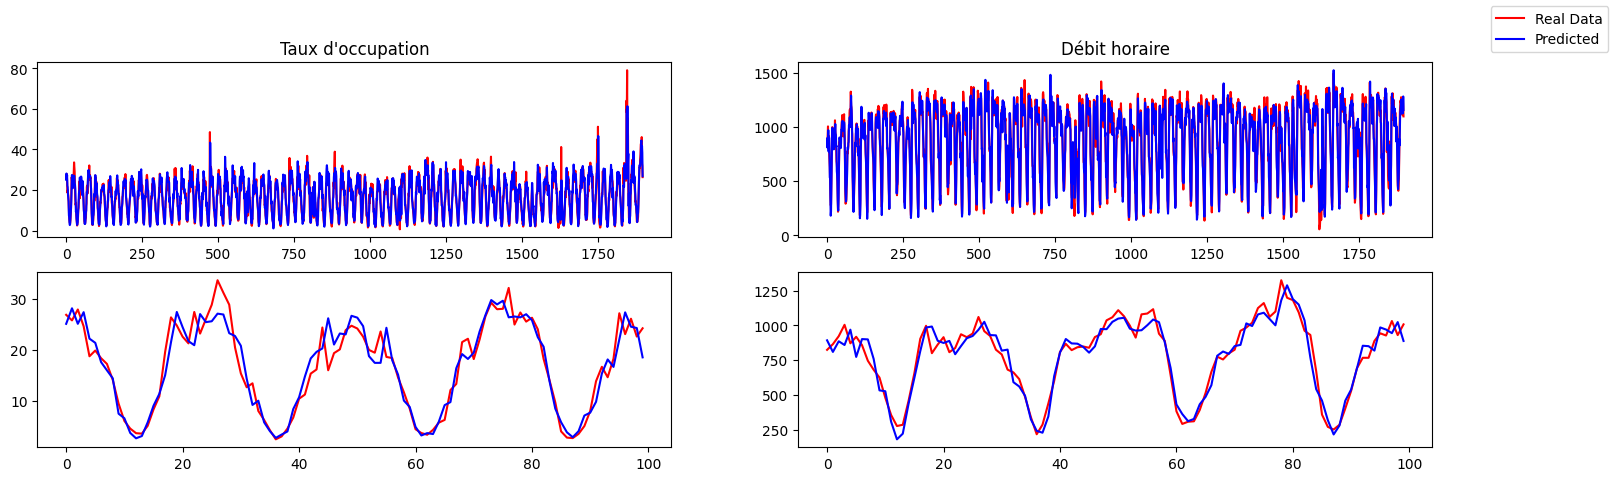

In [159]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 5))
n_taux_time_only = len(y_taux_test_time_only)
t_taux_time_only = np.arange(n_taux_time_only)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_time_only,y_taux_test_time_only, 'r')
ax[0,0].plot(t_taux_time_only,y_pred_taux_time_only_t, 'b')
ax[0,0].title.set_text("Taux d'occupation")

n_debit_time_only= len(y_pred_debit_time_only_t)
t_debit_time_only = np.arange(n_debit_time_only)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_time_only,y_debit_test_time_only, 'r')
ax[0,1].plot(t_debit_time_only,y_pred_debit_time_only_t, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_test_time_only[:100], 'r')
ax[1,0].plot(t_zoom,y_pred_taux_time_only_t[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_test_time_only[:100], 'r')
ax[1,1].plot(t_zoom,y_pred_debit_time_only_t[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

#### DIFF

In [219]:
##Fenetrage
def series_to_supervised_dif(df, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""

	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(i) - df[["Taux d'occupation",'Débit horaire']].shift(i+1))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(2)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[["Taux d'occupation",'Débit horaire']].shift(-i) - df[["Taux d'occupation",'Débit horaire']].shift(-1-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(2)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(2)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	df = df.merge(agg, left_index=True, right_index=True)
	# drop rows with NaN values
	if dropnan:
		df.dropna(inplace=True)
	return df


In [247]:
df_preprocessed_champs_dif = series_to_supervised_dif(df_champs,8, 1)
df_preprocessed_champs_dif = df_preprocessed_champs_dif.drop(columns=["Taux d'occupation","Débit horaire"]) 
y_taux_t_dif = df_preprocessed_champs_dif['var1(t)']
y_debit_t_dif = df_preprocessed_champs_dif['var2(t)']
X_dif = df_preprocessed_champs_dif.drop(columns=['var1(t)','var2(t)'])
X_dif = X_dif.drop(columns=['Libelle','Date et heure de comptage','date'])

## Data split 
offset = int(X.shape[0] * 0.7)
X_dif_train, y_taux_dif_train, y_debit_dif_train = X_dif[:offset], y_taux_t_dif[:offset], y_debit_t_dif[:offset]
X_dif_dif_test, y_taux_dif_test, y_debit_dif_test = X_dif[offset:], y_taux_t_dif[offset:], y_debit_t_dif[offset:]

## Features type declaration
min_max_columns_dif = ['vacances','est_ferie','year_2021','year_2022','hour_0','hour_1','hour_2','hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13','hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23','day_1','day_2','day_3','day_4','day_5','day_6','day_7','day_8','day_9','day_10','day_11','day_12','day_13','day_14','day_15','day_16','day_17','day_18','day_19','day_20','day_21','day_22','day_23','day_24','day_25','day_26','day_27','day_28','day_29','day_30','day_31','wday_Monday','wday_Tuesday','wday_Wednesday','wday_Thursday','wday_Friday','wday_Saturday','wday_Sunday','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12']
numerical_col_dif = [feature for feature in list(X_dif) if feature not in min_max_columns]


In [248]:

##Pipelines Scikit Learn
ct_scaler = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numerical_col_dif),
        ("scaler_minmax", MinMaxScaler(), min_max_columns_dif),
        
    ]
)

pipeline_master = Pipeline([
    ("preprocessor", ct_scaler),
    ])


In [249]:
## Data normalization
X_train_dif_preprocessed = pipeline_master.fit_transform(X_dif_train)
X_test_dif_preprocessed = pipeline_master.transform(X_dif_dif_test)

In [250]:
## Prediction of taux at t : 
model_taux_t_dif = xgb.XGBRegressor()
model_taux_t_dif = model_taux_t_dif.fit(X_train_dif_preprocessed,y_taux_dif_train)

model_debit_t_dif = xgb.XGBRegressor()
model_debit_t_dif = model_debit_t_dif.fit(X_train_dif_preprocessed,y_debit_dif_train)



In [251]:
y_pred_taux_t_dif = model_taux_t_dif.predict(X_test_dif_preprocessed)
MSE_taux_dif = mean_squared_error(y_taux_dif_test, y_pred_taux_t_dif)


y_pred_debit_t_dif = model_debit_t_dif.predict(X_test_dif_preprocessed)
MSE_debit_dif = s(y_debit_dif_test, y_pred_debit_t_dif)

print(MSE_taux_dif**0.5,MSE_debit_dif**0.5)

7.29599135677183 130.78480750456782


In [240]:
y_debit_dif_test.describe()

count   4703.00
mean      -0.84
std      149.98
min     -778.00
25%      -76.00
50%       13.00
75%       91.00
max      756.00
Name: var2(t), dtype: float64

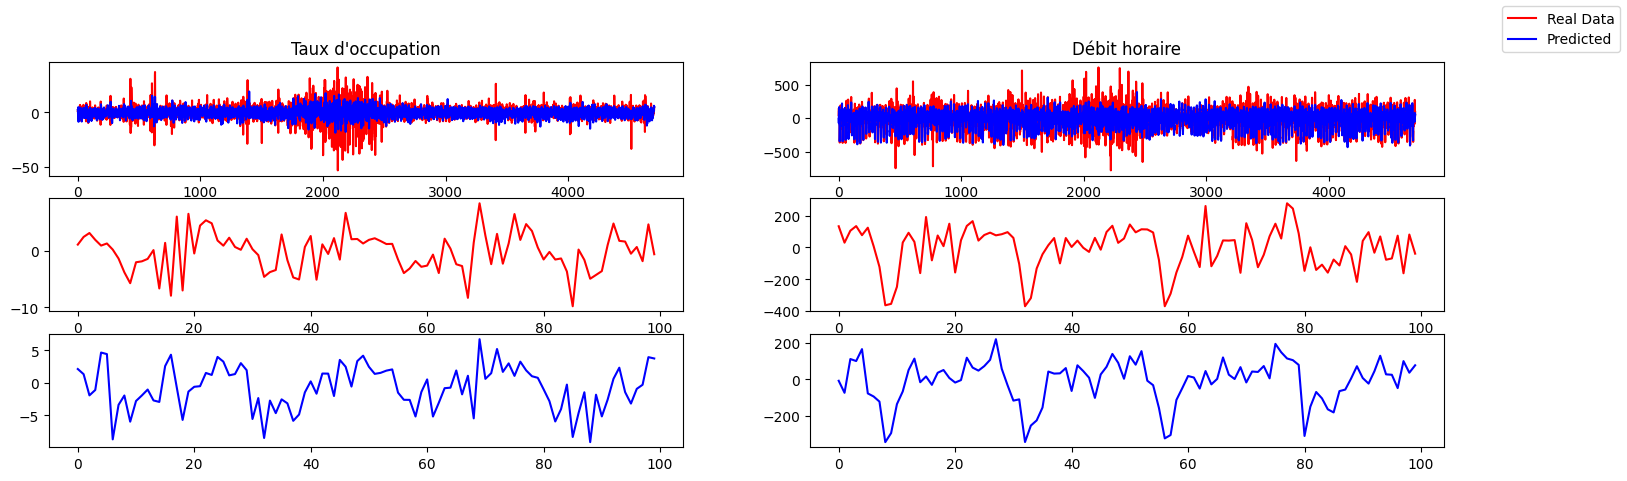

In [239]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(18, 5))
n_taux_dif = len(y_taux_dif_test)
t_taux_dif = np.arange(n_taux_dif)
# plt.figure("Taux d'occupation")
ax[0,0].plot(t_taux_dif,y_taux_dif_test, 'r')
ax[0,0].plot(t_taux_dif,y_pred_taux_t_dif, 'b')
ax[0,0].title.set_text("Taux d'occupation")

n_debit_dif= len(y_taux_dif_test)
t_debit_dif = np.arange(n_debit_dif)
# plt.figure("Débit horaire")
ax[0,1].plot(t_debit_dif,y_debit_dif_test, 'r')
ax[0,1].plot(t_debit_dif,y_pred_debit_t_dif, 'b')
ax[0,1].title.set_text("Débit horaire")

t_zoom = np.arange(100)
ax[1,0].plot(t_zoom,y_taux_dif_test[:100], 'r')
ax[2,0].plot(t_zoom,y_pred_taux_t_dif[:100], 'b')

ax[1,1].plot(t_zoom,y_debit_dif_test[:100], 'r')
ax[2,1].plot(t_zoom,y_pred_debit_t_dif[:100], 'b')
fig.legend(['Real Data','Predicted'])
plt.show()

_Grid Search on xgboost_ 
#### WIP